Imports

In [95]:
import pandas as pd
import numpy as np

# Graphic libraries
import matplotlib.pyplot as plt
import plotly.express   as px
import seaborn as sns

# Data preparation
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

# Feature extraction.
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Deactivating warnings of chanied assignation
pd.options.mode.chained_assignment = None

## Loading data, quick analysis.

I need to get a better understanding of what each field on the given dataset represents. 

Based on Google search, and the quick analysis i do below, the meanings i can give to these columns are:

* 'song_name', 'artist', 'album', 'duration_ms', 'artist_genres', 'artist_popularity', 'artist_folowers', and 'release_year' = The names of these columns are pretty specific.
* 'danceability' = Means how danceable a song is, the bigger the value the more danceable a song is.
* 'energy' = In music is usually used in relation to sound power. The high pich values have high frequencies and thus they represent high energy states. Also a bigger value indicates more energetic a song is.
* 'loudness' = Amount of intensity a sound wave has, it is measured in decibel units. (dB). The bigger the value the louder.
* 'mode' = Mode or modus its most commonly use may be described as a type of musical scale coupled with a set of characteristics melodic and harmonic behaviors. It is applied to major and minor keys. So Major would be represented by 1 and minor is 0. (<a href='https://en.wikipedia.org/wiki/Mode_(music)'>Link about mode</a>)
* 'key' = This field is related to the previous one and its a categorical field that each value represents a pitch. In set theory, an integer notation is used, wich assigns a number between 0 and 11 to each pitch class 0 = C, 1 = C#, 2 = D, and so on.(<a href="https://open.library.okstate.edu/musictheory/chapter/pitch-and-pitch-class/#:~:text=Pitch%20classes%20are%20given%20an,tone%20with%20an%20individual%20frequency.&text=A%20system%20of%20naming%20pitch,%2C%20D%20as%202%2C%20etc.">Link about pitch</a>)
* 'speechiness' = Detects the presence of spoken words in a track. A Value near 0 means that the song most likely has little voice singing.
* 'acousticness' = How a acustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
* 'instrumentalness' = How likely the music contains no spoken word vocals. So the closer to 1.0 the more instrumental the song is.
* 'liveness' = Presence of a live audience in song, a bigger value might indicate that the song was recorded live.
* 'valence' =  Describes if the song is likely to make someone feel happy or sad, higher values might be asociated to more happyness.
* 'tempo' = Is the speed of pace of a given song, its meassured in Beats Per Minute (BPM), the bigger the value then the more beats per minute it has.

* 'mode' and 'key' = I can't interpret the meaning of these fields so I'll try to figure them out in EDA.


In [96]:
data = pd.read_csv('./data/dataset_desafio.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   song_name          291 non-null    object 
 1   artist             291 non-null    object 
 2   album              291 non-null    object 
 3   danceability       291 non-null    float64
 4   energy             291 non-null    float64
 5   key                291 non-null    int64  
 6   loudness           291 non-null    float64
 7   mode               291 non-null    int64  
 8   speechiness        291 non-null    float64
 9   acousticness       291 non-null    float64
 10  instrumentalness   291 non-null    float64
 11  liveness           291 non-null    float64
 12  valence            291 non-null    float64
 13  tempo              291 non-null    float64
 14  duration_ms        291 non-null    int64  
 15  song_popularity    291 non-null    int64  
 16  artist_genres      291 non

In [97]:
# Lets pull out some statistics related to the data. Ill select the fields that I consider provide more information. 
# 1st of all im going to separate bewteen categorical columns and numerical column, in orther to facilitate Data Exploration.
mask_num_cols = (data.dtypes != 'object')
data_num_cols = data[data.dtypes.index[mask_num_cols]]
data_cat_cols = data[data.dtypes.index[~mask_num_cols]]

In [98]:
data_num_cols.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,2.910000e+02,291.000000
mean,0.577519,0.664526,5.402062,-8.009598,0.487973,0.064844,0.320144,0.074815,0.215163,0.594482,120.306581,226859.237113,44.075601,54.838488,2.741029e+06,2002.192440
std,0.169332,0.219575,3.628412,3.394579,0.500716,0.052145,0.313434,0.217098,0.201732,0.253076,28.324863,70661.662009,25.216876,19.259517,6.953692e+06,14.362214
min,0.103000,0.157000,0.000000,-18.752000,0.000000,0.025000,0.000004,0.000000,0.026500,0.038200,44.370000,86893.000000,0.000000,0.000000,1.300000e+01,1961.000000
25%,0.451500,0.490500,2.000000,-10.224500,0.000000,0.035100,0.033400,0.000000,0.091050,0.399000,98.558500,180967.000000,26.000000,45.000000,4.238850e+04,1991.000000
50%,0.587000,0.701000,6.000000,-7.178000,0.000000,0.045300,0.202000,0.000029,0.135000,0.617000,120.099000,217560.000000,50.000000,59.000000,4.685670e+05,2004.000000
75%,0.710500,0.853500,9.000000,-5.578000,1.000000,0.067650,0.577500,0.002630,0.260000,0.822000,136.165000,266126.500000,63.000000,67.000000,1.868729e+06,2014.500000
max,0.949000,0.986000,11.000000,-1.657000,1.000000,0.435000,0.984000,0.942000,0.970000,0.973000,193.660000,622000.000000,98.000000,91.000000,6.057431e+07,2022.000000


We can see that there isn't a lot of variation in the magnitude of the data, except for the 'duration_ms' variable (it has a lot of variation in the magnitude).

Since im planning on implementing K-Means, and this algorithm is distance-based, this difference in magnitude can create problems. So later on im planning to bring all the variables to the same magnitude by standardizing the data.

Another thing we can observe here is that probably we are going to have outliers due to the difference between the mean, the standard deviation, and the max value. So ill be investigating on that also later on, wheter if we need to eliminate them or we can ignore them.

## Null and duplicate presence analysis.

In [99]:
# Looking at a sample of the Dataset i could see, that for many rows, the column 'artist_genres' is an empty list.
len(data[data['artist_genres'] == "['[]']"])

41

In [100]:
# I will procede an replace this empty list with Nan Values.
data['artist_genres'].replace("['[]']", np.NAN, inplace=True)
data.isnull().sum()

song_name             0
artist                0
album                 0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_ms           0
song_popularity       0
artist_genres        41
artist_popularity     0
artist_followers      0
release_year          0
dtype: int64

In [101]:
data.duplicated().sum()

0

We can observe that there is no presence of nulls or either duplicates in the given dataset, so no imputation is needed.

## Outliers

In [102]:
# Checking outliers on numerical cols.
for i in data_num_cols.columns:
    fig = px.box(data, x=i)
    fig.update_layout(height=250, width=750)
    fig.show()

Okey, after inspecting the Data and seeing the outliers i've reached to the conclusion that i wont be removing outliers.

Seeing the outliers values, and with a bit more undersanding of the values each field can take, I can say that these outliers are valid data and representative of the sample. I strongly believe that they are legitimate values that represent important escenarios, removing them could disort the reality of the data, harm the analysis, and lead to a loss of important information.

Conclusions i get with this:
* K-Means algorithm its sensible to outliers (because it seeks to minimize the sum of the squared distances). So it could be a good starting point but not a reliable one, i will consider using other clustering algorithms that are more robust to the presence of outliers (DBSCAN or Meadian-Based algorithms).

## EDA

Lets do a Exploratory Data Analysis to get more insights from the given data.

In [103]:
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix)
fig.update_layout(height=850, width=850)
fig.show()

C:\Users\juanb\AppData\Local\Temp\ipykernel_24256\2211360409.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



This correlation matrix indicates the linear relationship between each variable. Positive correlation means that when one variable increase its value, other tends to increase as well. Negative correlation, means that when one variable increases, other thends to decreace.

From the correlation matrix we can say that:
* We cannot observe a significant positive or negative correlation between the given data. Also there are no signs of multicollinearity between the variables,
* 'danceability' is highly correlated with 'valence' (how happy a song makes you feel).
* The more energetic a song is the less acoustic it is and it has more loudnes. 'energy' and 'acousticness' are poorly correlated. Meanwhile 'energy' and 'loudness' are highly correlated. 
* Song Popularity is correlated positively with the Artist popularity, which make sense.

###  Artist with Most Songs

In [104]:
data_artist_amount_songs = data['artist'].value_counts().reset_index().sort_values('artist',ascending=False)[0:10]

# Changing names for interpretation.
data_artist_amount_songs.rename(columns={'index':'artist', 'artist' : 'total_amount_songs'}, inplace=True)

fig = px.bar(data_artist_amount_songs, x='artist', y='total_amount_songs')
fig.update_layout(height=500, width=750)
fig.show()

Artist with most songs is "Patricio Rey y sus Redonditos de Ricota" 

In [105]:
### Top 5 Artists.

In [106]:
# Grouping by artist, and obtaning its mean popularity, i use mean because i know that each artist has a unique popularity.
data_artist_grouped = data.groupby('artist', as_index=False)['artist_popularity'].mean()
# Now ill sort artis_popularity in descending form in order to keep only the most popular ones.
data_artist_grouped = data_artist_grouped.sort_values('artist_popularity', ascending=False).iloc[0:5]

fig = px.bar(data_artist_grouped, x='artist', y='artist_popularity')
fig.update_layout(height=500, width=500)
fig.show()

Lets see if the popular artists also hace the most popular songs.

In [107]:
# Grouping by artist, and obtaning its mean song popularity, in order to consider all artist songs and obtian a average song popularity value.
data_artist_grouped = data.groupby('artist', as_index=False)['song_popularity'].mean()
# Now ill sort artis_popularity in descending form in order to keep only the most popular ones.
data_artist_grouped = data_artist_grouped.sort_values('song_popularity', ascending=False).iloc[0:5]

fig = px.bar(data_artist_grouped, x='artist', y='song_popularity')
fig.update_layout(height=500, width=500)
fig.show()

Here we can see that out of the top 5 artist, 3 have the most popular songs (David Guetta, Eminem, and Shawn Mendes)

### Genre Popularity.

In [108]:
# Creating DF with no null on 'artist_genres'.
data_artist_genre = data[['artist_genres']].dropna(how='any').reset_index(drop=True)

# Empty list to append all genres
list_artist_genre = []

# Iterating over each row.
for index in range(len(data_artist_genre)):
    # i've observed that the column 'genres' has a list passed as values, so ill split into idividual values.
    # Obtaning all artist genres on the list of values.
    row_artist_genres = data_artist_genre.iloc[index]['artist_genres'].split(',')
    
    for genre in row_artist_genres:
        # Apending each genre to my created list.
        list_artist_genre.append(genre)


data_artist_genre = pd.DataFrame(list_artist_genre, columns=['artist_genres'])

# Removing '[' and ']'.
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace('[','', regex=False)
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace(']','', regex=False)

# Removing ', character.
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace("'",'', regex=False)

# Remove leading spaces from the 'column_name'
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace(r'^\s*', '', regex=True)

data_artist_genre = data_artist_genre.value_counts().sort_values(ascending=False).reset_index()[0:10]


# Renaming column, to give more sense.
data_artist_genre.rename(columns={0 : 'total_count'}, inplace=True)

fig = px.pie(data_artist_genre, values='total_count', names='artist_genres')
fig.update_layout(height=500, width=500)
fig.show()

Here we can see which are the most listened artist genres, "rock" get the most number of reproductions.

### Amount of song released each year.

In [109]:
df_song_release_per_year = data.groupby('release_year')['song_name'].count().reset_index().sort_values('song_name',ascending=False)

fig = px.bar(df_song_release_per_year, x='release_year', y='song_name')
fig.update_layout(height=500, width=1000)
fig.show()

The year in which the most songs were released was 2012, 5.5% of total songs in the dataset.

### Distribution of Audio Features along the years

In [110]:
cols_plot = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

data_groupesd_per_year = data.groupby('release_year')[cols_plot].mean().reset_index()

for i in cols_plot:
    
    fig = px.line(data_groupesd_per_year, x='release_year', y=i)
    fig.update_layout(height=350, width=1000)
    fig.show()



From this plots i can get good information, from data:
* The danceability of the songs tended to increase over time. And suffered less variation after the 2000.
* Energy in the songs was less variable between the 2000 and the 2010.
* Loudness has its lowest peak in 1964 and 1968 after that it suffered a great increase in its values.
* Speechiness is constant along all considered years. Except in 1979, when it experienced a peak.
* Acousticness tended to decreace.
* In all fields (except instrumentaless), the highest peak occurs around 1980, after that year the values tend to present less diference between the peaks.

## Data Wrangling

So know that i've made an EDA and have a bit more understanding of the data im working with, its time to prepare the data so that it can be consumed by the model.

The first this im going to do is to select my features or input variables.
In this case the data that will be useful to me is represented by the numerical fields.

The 'artist'genres' is an useful field. But, it has null presence, and too many genres in one list of values, so it isnt a reliable field to use. 
I could imputate those values based on the mean of the Audio feature for each genre, but i believe that it wont make much sense, so ill just ignore this field.

NOTE: i wont be maping and one-hot encoding the 'key' field instead im treating this variable as a labeled encoded, because this is an ordinal variable. Mode its already one-hot encoded.

In [111]:
feature_cols = data_num_cols.columns.to_list()
X = data[feature_cols]
X.sample(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
32,0.611,0.886,8,-9.843,0,0.0482,0.6000,0.000001,0.0732,0.955,119.264,117699,0,66,713503,2018
174,0.680,0.701,0,-10.460,1,0.0275,0.0341,0.004790,0.1140,0.824,103.789,253593,61,69,3118475,2004
170,0.556,0.924,0,-2.813,0,0.2130,0.5560,0.000003,0.2080,0.947,99.216,210210,44,54,218256,2014


Standarizing data in order to have the same scale along all my fields. This is neccesary because Clustering algorithms are based on distance.

In [112]:
# Its always good to keep a copie of the DF before applying any transformation to the data.
X_sc = X.copy()

In [113]:
# Bringing all variables to the same magnitude.
# Standard Scaler instance.
sc = StandardScaler()
# Fitting StandardScaler and adjusting magnitudes.
X_sc[feature_cols] = sc.fit_transform(X[feature_cols])

X_sc.sample(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
164,-0.310687,0.649981,-0.939232,0.485017,-0.976228,0.147081,-0.220982,-0.345209,-0.818145,0.579945,1.240990,-0.154894,0.950380,0.424495,-0.199896,0.544555
275,0.647659,-0.422112,-0.111000,-0.271901,1.024351,-0.125705,-0.323253,-0.341167,-0.472539,-0.061281,-0.858553,0.467546,-0.082452,-0.095623,-0.319342,1.242026
116,-1.061983,1.101629,-0.387078,0.603350,-0.976228,-0.335098,-0.989930,-0.339811,-0.323571,-0.227525,0.230669,0.305369,0.632586,0.372483,-0.202571,-0.431905


## Clustering

Now im going to excecute a first cluster algorithm, and see how it performs, later on im going to compare it with other algorithm.

In [114]:
# Stablishing a random_state.
rand_state  = 10

In [115]:
def select_number_of_cluster (df_feature, max_num_of_clusters=14, init_method='k-means++'):
    '''
        This function is used to evaluate Kmeans, and indicate how many clusters should be used. 
        By using the elbow rule.
        
        The input of this function are:
            - df_features = Features to train kmeans model.
            - max_num_of_cluster = Int, its used to determine the max number of cluster to consider.
            - init_method = method for initialization.
            
        The Output will be:
            - Three plots = one for each metric (inertia, silhouse, calinski)
                from here we can select the optimum cluster value.
    '''
    # List to store all inertia values.
    inertia_scores_list = []
    # List to store all silhouett scores.
    silhouse_scores_list = []
    # List to store all calinski scores.
    calinski_scores_list = []
    # List to store number of cluser.
    cluster_list = []
    
    for k in range(2,max_num_of_clusters):
        # Instancing and traning the kmeans algorithms.
        kmeans = KMeans(n_clusters=k, init=init_method, random_state=rand_state)
        kmeans.fit_predict(df_feature)
        
        # Obtaning an appending scores:
        #   Inertia.
        inertia_scr = kmeans.inertia_
        inertia_scores_list.append(inertia_scr)
        
        #   silhouett.
        silhouette_scr = silhouette_score(df_feature, kmeans.labels_)
        silhouse_scores_list.append(silhouette_scr)

        #   calinski.
        calinski_scr = calinski_harabasz_score(df_feature, kmeans.labels_)
        calinski_scores_list.append(calinski_scr)
        
        # Storing k.
        cluster_list.append(k)
    
    df_scores =  pd.DataFrame()
    df_scores['number_cluster'] = cluster_list
    df_scores['inertia'] = inertia_scores_list
    df_scores['silhouette'] = silhouse_scores_list
    df_scores['calinski'] = calinski_scores_list
    
    plot_cols = ['inertia', 'silhouette', 'calinski']
    
    for i in plot_cols:
        fig = px.line(
            df_scores, 
            x='number_cluster', 
            y=i, 
            title='Number of cluster variation %s' %(i)
        )
        fig.update_layout(height=350, width=750)
        fig.show()

In [116]:
select_number_of_cluster(X_sc,max_num_of_clusters=15)

ill be using the elbow rule on the inertia graph and the silhouette graph, because calinski graph doesnt have a well defined peak.

Based on the 1st graph an using the elbow rule, i can say that an optimum number of clusters is k=8.

Using the 2nd graph and the Average Silhouette Method, seeing which clusters maximize the average silhoutte the optimum values are k=2 or k=5.

Ill use k = 8.

Now lets apply K-mean to our data to create clusters.

In [117]:
# Initializing the class object.
kmeans = KMeans(n_clusters=8, random_state=rand_state)

# Predicting labels of clusters.
label = kmeans.fit_predict(X_sc)

## Vizualize generated clusters

To visualize the generated clusters, we will first need to reduce the data to two dimensions, using PCA. So we can plot it on a scatter plot.

Ill create a function to do this.

In [142]:
def clustering (df_features, labels, print_info=True):
    '''
        This function takes:
            - df_features =  dataframe that was used to train clusters.
            - labels = labels that was assigned to each row of the Feature DataFrame.
        It returns:
            - Dataframe with PCA applied, this is a DF with reduced dimensions, and with each 
                cluster class assosiated to it.
            - Plots in which to visualize the generated clusters.
            - Printed information about labels, and its balance, and different metrics to compare.
            
        So this functions is used to generate insights about a clustered DF. First it will apply PCA
        to reduce dimensionality, i do this because the difference between clusters will be easier to see.
        
        After the dimensionality reduction the clusters will be ploted, one plot is to visualize all clusters,
        and then there will be a plot for every cluster class there is, diferentiatin a given cluster from the 
        other clusters.
        
        Then if 'print_info' is enabled, the function will print usefull information like:
            - Number of elements on a given cluster, and the proportion that the cluster takes in the given sample.
            - Inertia score.
            - silhouse score.
            - calinski score.
    '''
    
    # Initializing a PCA model with 2 components.
    pca = PCA(n_components=2)
    # Reducing data to two dimensions using PCA model.
    features_2d = pca.fit_transform(df_features)
    
    # Creating DF
    df_features_2d = pd.DataFrame(data=features_2d, columns=['0','1'])
    # Apending clusters.
    df_features_2d['cluster'] = labels
    
    # setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    
    sns.scatterplot(df_features_2d, x='0', y='1', hue='cluster', style='cluster', palette='deep')
    plt.show()
    
    # Get the unique cluster assignments.
    unique_clusters = df_features_2d['cluster'].sort_values().unique()
    
    # Iterate over the clusters.
    for i, unique_cluster in enumerate(unique_clusters):
        # Creating a copy of the features Df, so i can create a column to separate between the considered cluster and the not considered.
        plot_cluster = df_features_2d.copy()
        # Selecting data points that belong to current cluster.
        cluster_rows = df_features_2d['cluster'] == unique_cluster
        # Selecting data that belongs to the other clusters.
        other_cluster_rows = df_features_2d['cluster'] != unique_cluster
        
        
        plot_cluster.loc[cluster_rows,'hue_col'] = 'Cluster %s' %(unique_cluster)
        plot_cluster.loc[other_cluster_rows, 'hue_col'] = 'Other Clusters'
        
        # Reordering Df so it show 1st the number of cluster.
        plot_cluster = plot_cluster.sort_values('hue_col')
        
        # setting the dimensions of the plot
        fig, ax = plt.subplots(figsize=(4, 4))
        color_palette = ['#08090D', '#B3B8C8']
        sns.set_palette(color_palette)
        sns.scatterplot(plot_cluster, x='0', y='1', hue='hue_col', size='hue_col', sizes=(20,50))
        plt.show()
    
    return plot_cluster

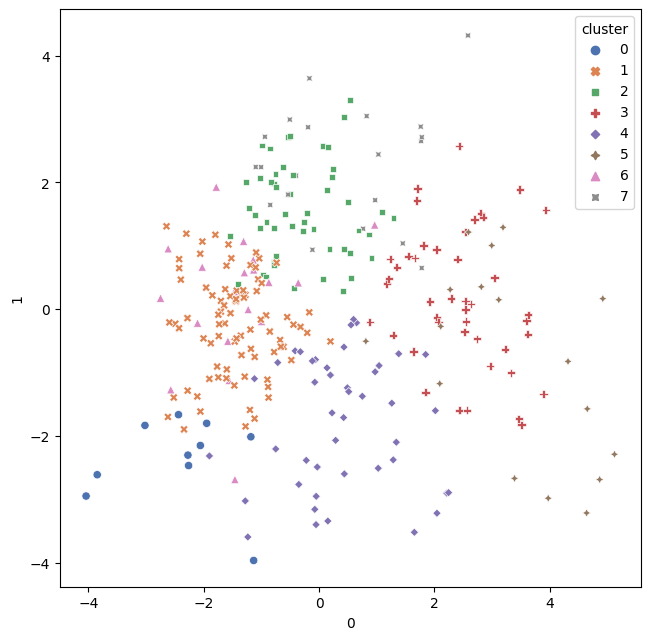

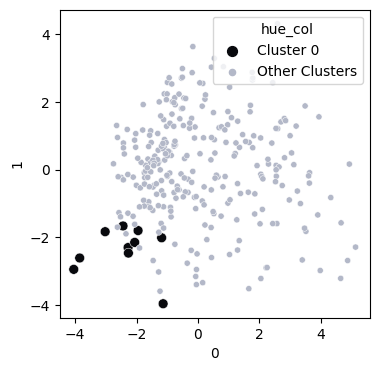

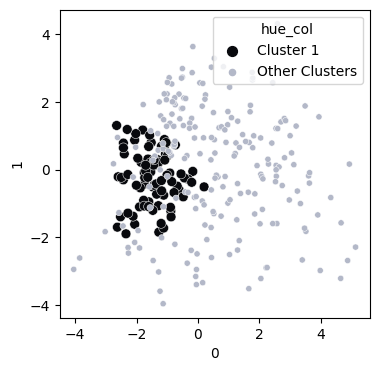

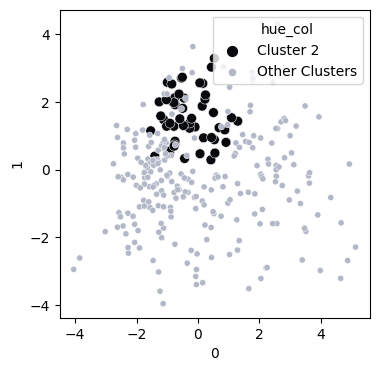

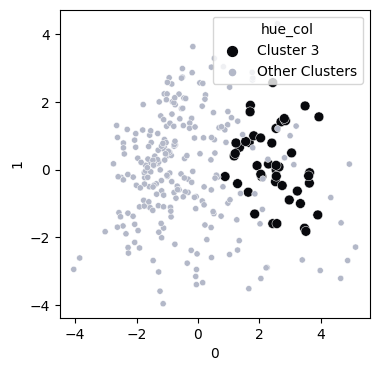

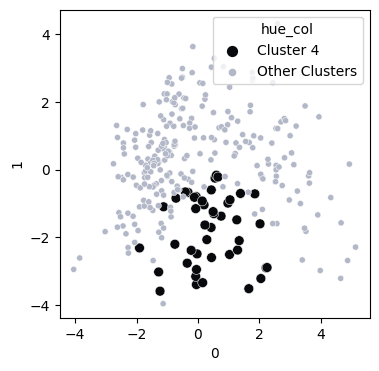

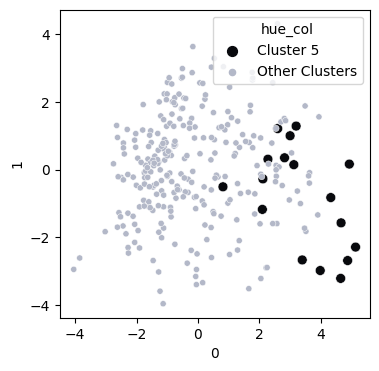

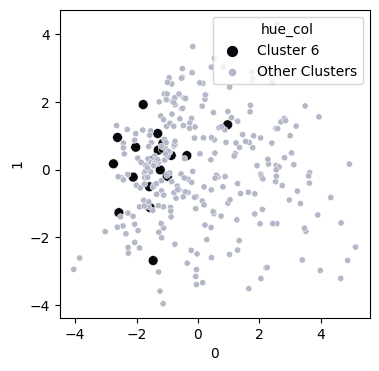

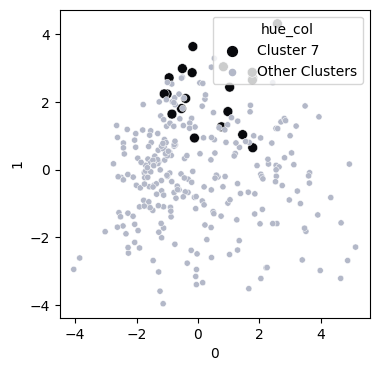

In [143]:
a = clustering(X_sc, label)